In [1]:
import csv 
import numpy as np
import pandas as pd
import sys
import platform
system = platform.system()
if system =='Linux':
    sys.path.append('/home/lucas/Documents/Log_Analysis/Battery')
elif system =='Darwin':
    sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis')
#sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis/Battery')
from battery import OCVcurve, Thevenin
import analog
from scipy.interpolate import interp1d as interp1d
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
path2curve = 'Battery 9 (RIP)/Discharge 200mA/SOCvsOCV_discharge200mA.csv'
curve = OCVcurve(path2curve)

### Import the test file

In [3]:
if system == 'Linux':
    folder = '/home/lucas/Documents/Log_Analysis/Logs/KF Testing/Luigi/'
elif system == 'Darwin':
    folder = '/Users/Lucas/Documents/Travail/Yuneec/Logs/KF Testing/Luigi/'
    
log_file = analog.pathfromQGC(folder,index=0)

#log_file = analog.pathfromgazebo('2019-10-29','09_24_54',firmware='yuneec')

print(log_file)
info = analog.logextract(log_file,['battery_status','vehicle_local_position'])
print(info.keys())

# From battery_status
current = info['battery_current']
current_filtered = info['battery_filtered_current']
SOC = info['remaining']
time = info['time_bs']
n_cells = info['n_cells']
voltage = info['battery_voltage']/n_cells
kalman_gain = info['kalman_gain']
kalman_gain = np.squeeze(kalman_gain)
covx = info['covx']
innovation = info['innovation']
iR1 = info['iR1']

# discard timestamps with non-initalized battery
current = current[voltage>0]
current_filtered = current_filtered[voltage>0]
SOC = SOC[voltage>0]
time = time[voltage>0]
kalman_gain = kalman_gain[:,voltage>0]
covx = covx[:,:,voltage>0]
innovation = innovation[voltage>0]
iR1 = iR1[voltage>0]
voltage = voltage[voltage>0] # to be done at the end
print(len(time))

# From vehicle_local_position
x = info['x']
y = info['y']
z = info['z']
time_vlp = info['time_vlp']





/home/lucas/Documents/Log_Analysis/Logs/KF Testing/Luigi//log_0_2019-11-13-14-35-11.ulg
dict_keys(['time_vlp', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'covx', 'kalman_gain', 'innovation', 'iR1', 'time_bs', 'n_cells', 'battery_current', 'battery_filtered_current', 'battery_voltage', 'battery_filtered_voltage', 'discharged_mah', 'remaining'])
114047


# Kalman filter analysis

## Vehicle position

<IPython.core.display.Javascript object>


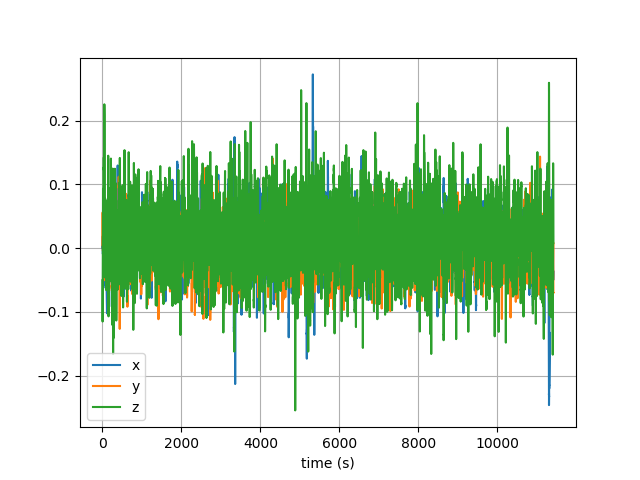

In [14]:
plt.figure()
plt.plot(time_vlp,x,label='x')
plt.plot(time_vlp,y,label='y')
plt.plot(time_vlp,z,label='z')
plt.xlabel('time (s)')
plt.legend()
plt.grid()

## Battery in & out

In [10]:
current_filtered_new = []
current_filtered_new = np.array(current[0:2])

for k in range(2,len(current)):
    current_filtered_new = np.append(current_filtered_new,0.02*current[k]+0.98*current_filtered_new[k-1]+0.00*current_filtered_new[k-2])

<IPython.core.display.Javascript object>


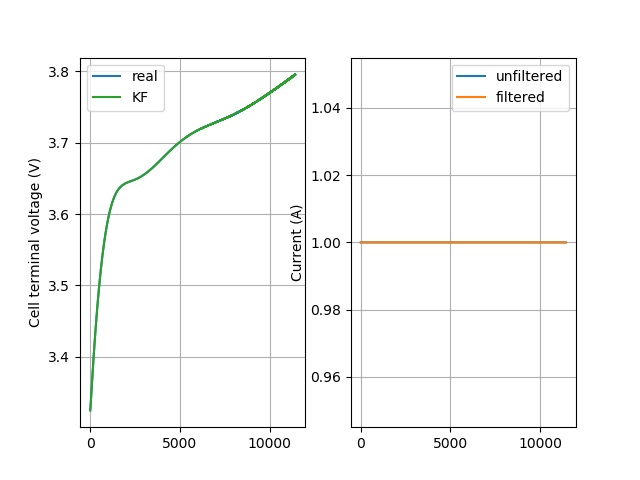

3.3247483571370444


In [11]:
%matplotlib notebook
plt.subplot(121)
plt.plot(time,voltage,label='real')
plt.plot(time,voltage-innovation,color='C2',linestyle='-',label='KF')
plt.legend()
plt.grid()
plt.ylabel('Cell terminal voltage (V)')

plt.subplot(122)
plt.plot(time,current,label='unfiltered')
plt.plot(time,current_filtered,label='filtered')
#plt.plot(time,current_filtered_new,label='filtered new')
plt.legend()
plt.grid()
plt.ylabel('Current (A)')
plt.show()
print(voltage[0])

In [12]:
current[time>100][0]
print((4.16-4.08)/5.35)

0.014953271028037398


## State estimation

<IPython.core.display.Javascript object>


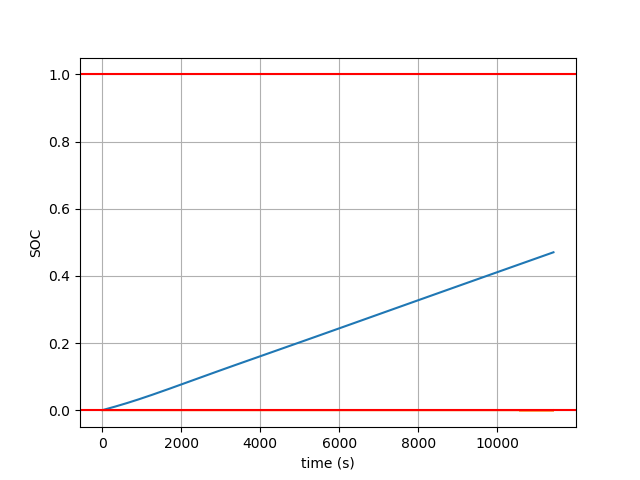

In [15]:
plt.figure()
plt.plot(time,SOC)
plt.plot(time,innovation/np.max(1),linestyle='-',alpha=0.7)
plt.axhline(0,color='r')
plt.axhline(1,color='r')
plt.xlabel('time (s)')
plt.ylabel('SOC')
plt.grid()
plt.show()

Changes in SOC are due to model innacuracies. The KF tries to modify the states to make the estimate output approach the sensed one.

In [98]:
print(max(innovation[:int(len(innovation)/2)]))
argmax_inno = np.argmax(innovation[:int(len(innovation)/2)])
print(f'SOC at first voltage drop : {SOC[argmax_inno:argmax_inno+50]}')


0.39111233
SOC at first voltage drop : [0.987098   1.         1.         1.         1.         1.
 0.9996285  0.9740631  0.96510106 0.96429664 0.96458226 0.95854
 0.95602375 0.9509204  0.944367   0.94058144 0.9377866  0.9374914
 0.9328696  0.929509   0.9266916  0.9223899  0.9192707  0.9157935
 0.913242   0.9119747  0.91073024 0.91092396 0.9100279  0.9083389
 0.908197   0.9060634  0.90640044 0.9055496  0.9037057  0.9039858
 0.903601   0.9050299  0.90530753 0.9056315  0.90471447 0.90353173
 0.90357035 0.9046794  0.91615224 0.9052695  0.9047292  0.9062805
 0.90776116 0.9113611 ]


# Covariance of states

<IPython.core.display.Javascript object>


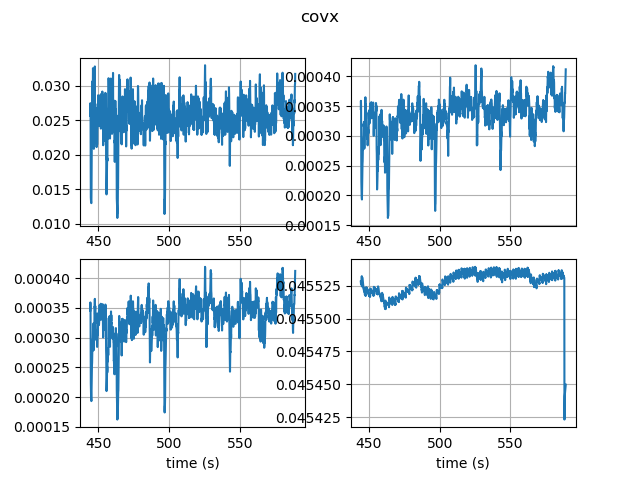

[[0.02568074 0.00034545]
 [0.00034545 0.04552813]]
[[0.0317481  0.00041198]
 [0.00041198 0.04544968]]


In [99]:
# initialization is done at (0.3,0);(0,0.1)

plt.figure()
plt.suptitle('covx')

plt.subplot(221)
plt.plot(time,covx[0,0])
plt.grid()

plt.subplot(222)
plt.plot(time,covx[0,1])
plt.grid()

plt.subplot(223)
plt.plot(time,covx[1,0])
plt.xlabel('time (s)')
plt.grid()

plt.subplot(224)
plt.plot(time,covx[1,1])
plt.xlabel('time (s)')
plt.grid()

# must be symetric and positive-definite at all times 

print(covx[:,:,0])
print(covx[:,:,-1])

## Kalman gain & innovation

In [100]:
measurement_update0 = []
measurement_update1 = []

for k in range(len(innovation)):
    measurement_update0 = np.append(measurement_update0,kalman_gain[0,k]*innovation[k])
    measurement_update1 = np.append(measurement_update1,kalman_gain[1,k]*innovation[k])

<IPython.core.display.Javascript object>


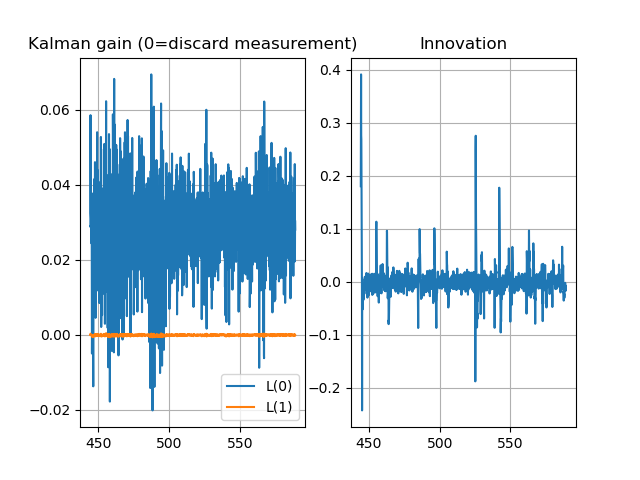

<IPython.core.display.Javascript object>


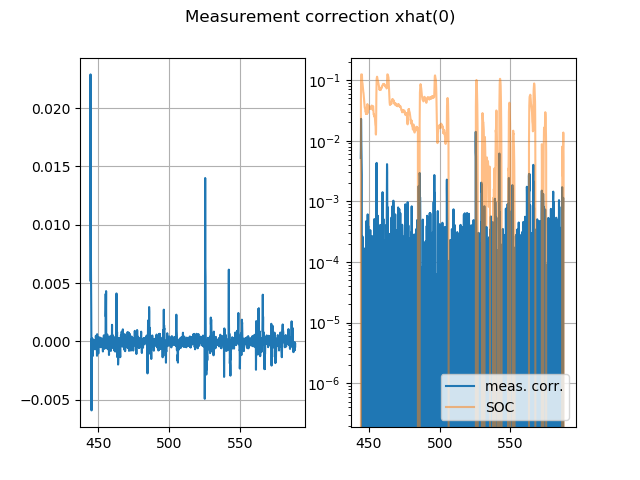

<IPython.core.display.Javascript object>


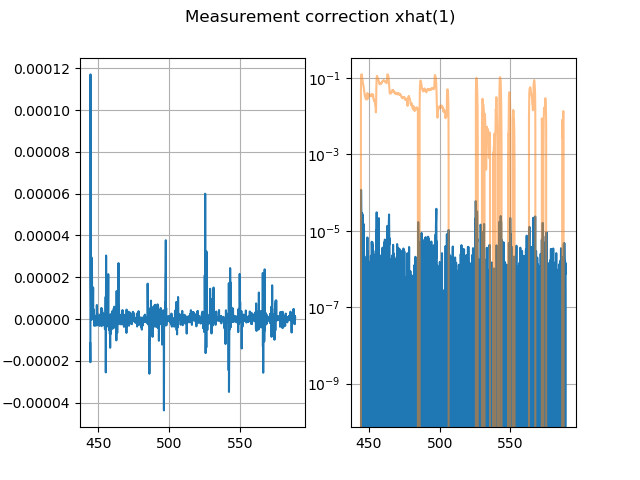

In [101]:
%matplotlib notebook

plt.figure()
plt.subplot(121)
plt.title('Kalman gain (0=discard measurement)')
plt.plot(time,kalman_gain[0,:].transpose(),label='L(0)')
plt.plot(time,kalman_gain[1,:].transpose(),label='L(1)')
plt.grid()
plt.legend()

plt.subplot(122)
plt.title('Innovation')
plt.plot(time,innovation) # inno = y - yhat
plt.grid()

plt.figure()
plt.suptitle('Measurement correction xhat(0)')
plt.subplot(121)
plt.plot(time,measurement_update0,label='meas. corr.')
plt.grid()
plt.subplot(122)
plt.semilogy(time,measurement_update0,label='meas. corr.')
plt.semilogy(time,SOC-SOC[0],alpha=0.5,label='SOC')
plt.legend()
plt.grid()

plt.figure()
plt.suptitle('Measurement correction xhat(1)')
plt.subplot(121)
plt.plot(time,measurement_update1,label='meas. corr.')
plt.grid()
plt.subplot(122)
plt.semilogy(time,measurement_update1,label='meas. corr.')
plt.semilogy(time,SOC-SOC[0],alpha=0.5,label='SOC')
#plt.legend()
plt.grid()

<IPython.core.display.Javascript object>


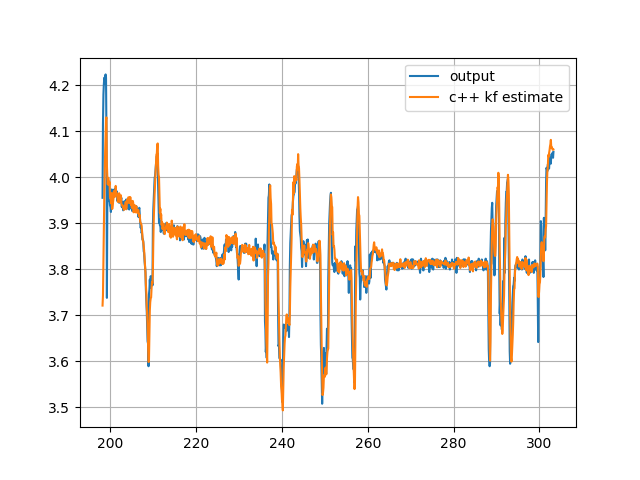

3.9554076194763184
90.5


In [52]:
y = voltage

plt.figure()
plt.plot(time,y,label='output')
plt.plot(time,y - innovation,label='c++ kf estimate')
plt.grid()
plt.legend()
plt.show()
print(voltage[0])
print(current[0])

# Simulation


In [102]:
ECparams = pd.read_csv('ECparams.csv')
R0 = float(ECparams['R0'])
R0 = 0.015
R1 = float(ECparams['R1'])
R1 = 0.01
C1 = float(ECparams['C1'])
C1 = 1100
print([R0,R1,C1])

[0.015, 0.01, 1100]


### Tune some more simulation parameters

In [103]:
Q = 6500*3.6 # has to be in Coulombs
eta = 1
# z0 = curve.SOCfromOCV(np.mean(voltage[0])+R0*current[0]) # taken from log to be tested
z0 = np.mean(SOC[0:100])
print(f'z0 = {z0}')
simbat = Thevenin(z0,Q,curve,R0,R1,C1)

z0 = 0.920391857624054


In [104]:
print(f'True measured initital voltage is {voltage[0]:.2f} V')
print(f'True initial OCV would then be {voltage[0]+R0*current[0]:.2f} V, because initial current is {current[0]:.2f} A')

True measured initital voltage is 3.96 V
True initial OCV would then be 5.32 V, because initial current is 90.98 A


### Run the simulation using the state-space model

<IPython.core.display.Javascript object>


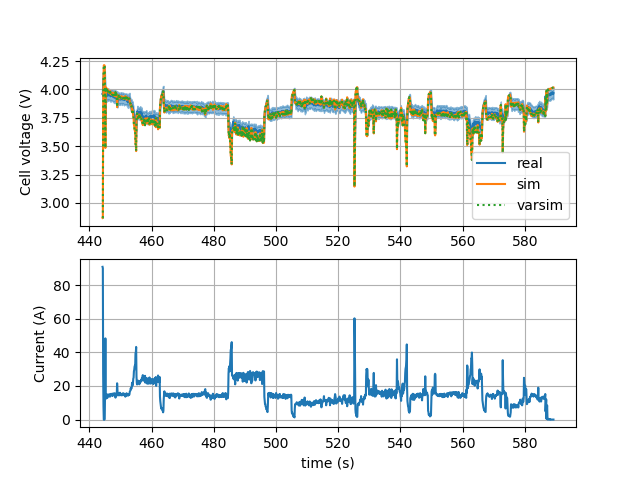

<IPython.core.display.Javascript object>


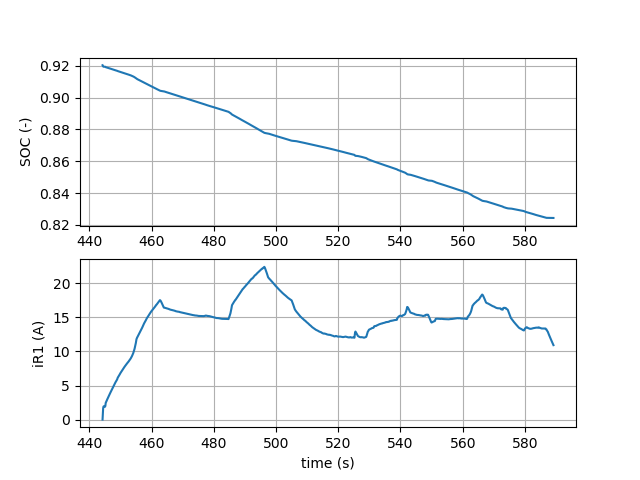

In [105]:
%matplotlib notebook
vsim = simbat.simulate(time,current,plot=False)
simbat.statespace(np.mean(np.diff(time)))
vlsim = simbat.lsim(time,current,curve)
varsimv = simbat.varsim(time,current,curve)
std = 0.023633527

plt.figure()
plt.subplot(211)
plt.fill_between(time,voltage + 2*std, voltage - 2*std,color='C0', alpha=.5)
plt.plot(time,voltage,color='C0',label='real')


plt.plot(time,vsim,color='C1',label='sim',alpha=1)
#plt.plot(time,vlsim+3.6,label='linsim')
plt.plot(time,varsimv,color='C2',label='varsim',linestyle=':')
plt.legend()
plt.grid()
plt.ylabel('Cell voltage (V)')
plt.subplot(212)
plt.plot(time,current)
plt.xlabel('time (s)')
plt.ylabel('Current (A)')
plt.grid()
plt.show()

plt.figure()
plt.subplot(211)
plt.plot(time,simbat.simz[:-1],label='sim')
plt.ylabel('SOC (-)')
plt.grid()
plt.subplot(212)
plt.plot(time,simbat.simi1[:-1],label='sim')
plt.xlabel('time (s)')
plt.ylabel('iR1 (A)')
plt.grid()

In [108]:
xplus0 = np.array([[z0],[0.]]) # is a stack of 2x1 arrays = a 2xk array
#covxplus0 = np.array([[1e-2,0.],[0., 0.]]) # is a stack of 2x2 arrays
covxplus0 = np.array([[0.,0.],[0., 0.]])
#covw = np.array([[1e-4, 0.],[0., 1e-4]])
covw = np.array([[1e-3, 0.],[0., 1]]) # is a constant 2x2 array
covv = 0.5017 + 0.5# is a constant 1x1 array

xminus = np.array([]) # is a stack of 2x1 arrays = a 2xk array
covmxminus = np.array([]) # is a stack of 2x2 arrays
yhat = np.array([]) # is a stack of 1x1 arrays = a 1-D array
xplus = np.array([]) # is a stack of 2x1 arrays = a 2xk array
covxplus = np.array([]) # is a stack of 2x2 arrays
covxy = np.array([]) # is a stack of 2x1 arrays = a 2xk array
covy = np.array([]) # is a stack of 1x1 arrays = a 1-D array
L = np.array([]) # is a stack of stack of 2x1 arrays = a 1-D array

u = current # is a stack of 1x1 arrays = a 1-D array
y = voltage # is a stack of 1x1 arrays = a 1-D array
print(z0)
kfbat = Thevenin(z0,Q,curve,R0,R1,C1)

0.92039186


In [109]:
n = len(time-1)
for k in range(len(y[:n+1])):
    #print(f'\n New iteration k={k}')
    
    #if k==0:
        #print(f'Real value of z : {simbat.simz[k]}, a posteriori estimated value of z : {xplus0[0]}')
        #print(f'Real value of i1 : {simbat.simi1[k]}, a posteriori estimated value of i1 : {xplus0[1]}')
    #else:
        #print(f'Real value of z : {simbat.simz[k]}, a posteriori estimated value of z : {xplus[0,-1]}')
        #print(f'Real value of i1 : {simbat.simi1[k]}, a posteriori estimated value of i1 : {xplus[1,-1]}')
    
    if k == 0: 
        kfbat.reset(R0,R1,C1,xplus0[0])
        # kfbat.reset(R0,R1,C1,SOC[0])
    else: 
        kfbat.reset(R0,R1,C1,xplus[0,k-1])
        # kfbat.reset(R0,R1,C1,SOC[k])
    kfbat.statespace(simbat.simdt)
    
    
    #print(f'Matrix C is {kfbat.C}')
    
    
    # 1 : Prediction update
    
    # 1a State prediction
    
    if k==0: 
        alpha = np.reshape(kfbat.A@xplus0,(2,1))
        xminus = alpha
    
    else : 
        alpha = np.reshape(kfbat.A@xplus[:,k-1],(2,1))
        beta = kfbat.B*u[k-1]
        xminus = np.concatenate([xminus, alpha + beta],axis=1)
    
    if xminus[0,k] > 1.0:
        xminus[0,k] = 1.0
    elif xminus[0,k] < 1e-3:
        xminus[0,k] = 1e-3
    
    #if k==0:
        #print(f'Real value of z : {simbat.simz[k]}, a priori estimated value of z : {xplus0[0]}')
        #print(f'Real value of i1 : {simbat.simi1[k]}, a priori estimated value of i1 : {xplus0[1]}')
    #else:
        #print(f'Real value of z : {simbat.simz[k]}, a priori estimated value of z : {xplus[0,-1]}')
        #print(f'Real value of i1 : {simbat.simi1[k]}, a priori estimated value of i1 : {xplus[1,-1]}')
    
    
    #print(f'xminus is {np.shape(xminus)}, should be 2x{k+1}')
    
    # kfbat.reset(R0,R1,C1,xminus[0,-1])
    kfbat.reset(R0,R1,C1,SOC[k])
    kfbat.statespace(simbat.simdt)
    
    
    # 1b State covariance a priori
    
    if k==0 :
        covxminus = kfbat.A@covxplus0@kfbat.A.T + covw
    elif k==1: 
        covxminus = np.dstack([covxminus,kfbat.A@covxplus@kfbat.A.T + covw])
    else :
        covxminus = np.dstack([covxminus,kfbat.A@covxplus[:,:,-1]@kfbat.A.T + covw])
    #print(f'covxminus = {covxminus}')    
    #print(f'covxminus is {np.shape(covxminus)}, should be 2x2x{k+1}')
    
    # 1c : Output predicition
    
    if k==0: 
        yhat = kfbat.OCVcurve.OCVfromSOC(xminus[0,k]) - R1*xminus[1,k] + kfbat.D*u[k]
        # for testing the output equation
        # yhat = kfbat.OCVcurve.OCVfromSOC(SOC[k]) - R1*iR1[k] + kfbat.D*u[k]
    else : 
        yhat = np.concatenate([yhat,kfbat.OCVcurve.OCVfromSOC(xminus[0,k]) - R1*xminus[1,k] + kfbat.D*u[k]])
        # for testing the output equation
        # yhat = np.concatenate([yhat,kfbat.OCVcurve.OCVfromSOC(SOC[k]) - R1*iR1[k] + kfbat.D*u[k]])
    #print(f'y : {y[k]}')  
    #print(f'yhat : {yhat[k]}')
    #print(f'yhat is {np.shape(yhat)}, should be {k+1}')
    
    # 2 : Measurement update
    
    # 2a Kalman gain computation
    
    if k==0:
        covxy = np.reshape(covxminus@kfbat.C.T,(2,1))
        covy = np.reshape(kfbat.C@covxminus@kfbat.C.T + covv,1)
        np.reshape(covxminus@kfbat.C.T,(2,1))
        L = covxy/covy
    else : 
        covxy = np.concatenate([covxy,np.reshape(covxminus[:,:,k]@kfbat.C.T,(2,1))],axis=1)
        #print(f'covxy is {np.shape(covxy)}, should be {2,k+1}')
        #print(np.shape(kfbat.C@covxminus[:,:,k]@kfbat.C.T + covv))
        covy = np.concatenate([covy,np.reshape(kfbat.C@covxminus[:,:,k]@kfbat.C.T + covv,1)])
        L = covxy/covy
    #print(f'covy is {np.shape(covy)}, should be {k+1}')
    
    #print(f'covxy = {covxy[:,k]}')      
    #print(f'Lk={np.reshape(L[:,-1],(2,1))}')
    
    #print(f'L is {np.shape(L)}, should be 2x{k+1}')
          
    # 2b State estimate correction
          
    inno = y[k] - yhat[k]
    if inno > 0.05:
        inno = 0.05
    elif inno < -0.05:
        inno = -0.05
        
    #print(f'Innovation : {inno}')
    
    if k==0:
        xplus = xplus0
        #print(f'xplus is {np.shape(xplus)}, should be 2x{k+1}')
    else : 
        xplus = np.concatenate([xplus,np.reshape(xminus[:,k],(2,1)) + np.reshape(L[:,k]*inno,(2,1))],axis=1)
        # xplus = np.concatenate([xplus,np.reshape(xminus[:,k],(2,1)) + np.reshape(kalman_gain[:,k]*innovation[k],(2,1))],axis=1)
        #print(f'xplus is {np.shape(xplus)}, should be 2x{k+1}')
        if xplus[0,k] > 1.0:
            xplus[0,k] = 1.0
        elif xplus[0,k] < 1e-3:
            xplus[0,k] = 1e-3
    
    # 2c State covariance a posteriori 
    if k==0: 
          covxplus = covxminus - L*kfbat.C@covxminus
    else :
        covxplus = np.dstack([covxplus,covxminus[:,:,k] - L[:,k]*kfbat.C@covxminus[:,:,-1]])
        #print(covxplus[:,:,k])
    #print(f'covxplus is {np.shape(covxplus)}, should be 2x2x{k+1}')    
    

<IPython.core.display.Javascript object>


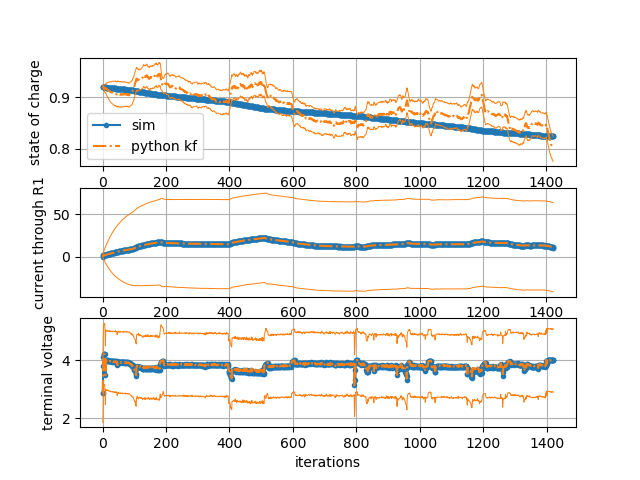

In [111]:
plt.figure()

plt.subplot(311)
plt.plot(simbat.simz[:n+1],'.-',label='sim')
plt.plot(xminus[0,:],linestyle='-.',label='python kf')
plt.plot(xminus[0,:]+covxminus[0,0,:],color='C1',linewidth=0.7)
plt.plot(xminus[0,:]-covxminus[0,0,:],color='C1',linewidth=0.7)
#plt.plot(xplus[0,:],'.-')
plt.legend()
plt.ylabel('state of charge')
plt.grid()

plt.subplot(312)
plt.plot(simbat.simi1[:n+1],'.-',label='sim')
plt.plot(xplus[1,:],'-.',color='C1',label='KF')
plt.plot(xplus[1,:]+covxplus[1,1,:],color='C1',linewidth=0.7)
plt.plot(xplus[1,:]-covxplus[1,1,:],color='C1',linewidth=0.7)
plt.ylabel('current through R1')
plt.grid()

plt.subplot(313)
plt.plot(simbat.simv[:n+1],'.-',label='sim')
plt.plot(yhat,'-.')
plt.plot(yhat+covy,color='C1',linewidth=0.7)
plt.plot(yhat-covy,color='C1',linewidth=0.7)
plt.xlabel('iterations')
plt.ylabel('terminal voltage')
plt.grid()

In [72]:
print(kfbat.A)
print(simbat.A)

[[1.         0.        ]
 [0.         0.99079964]]
[[1.         0.        ]
 [0.         0.99131358]]


# Output comparison

<IPython.core.display.Javascript object>


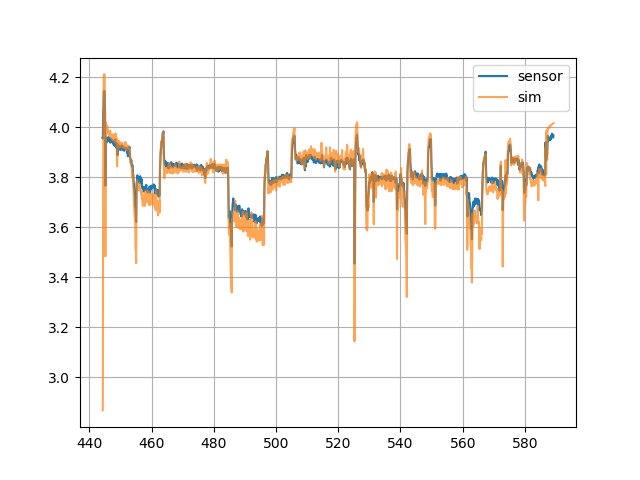

In [112]:
plt.figure()
plt.plot(time,y,label='sensor',alpha=1)
plt.plot(simbat.simt,simbat.simv,label='sim',alpha=0.7)
#plt.plot(simbat.simt[:n+1],yhat,label='python kf',linestyle='-')

# plt.plot(simbat.simt[:n+1],yhat+covy,color='C2',linestyle=':')
# plt.plot(simbat.simt[:n+1],yhat-covy,color='C2',linestyle=':')
#plt.plot(time[:n+1],voltage[:n+1]-innovation[:n+1],label='c++ kf',linestyle='-')
plt.grid()
plt.legend()
plt.show()

Python Kalman filter performs well for output prediction -> the translation to state of charge does not work properly

<IPython.core.display.Javascript object>


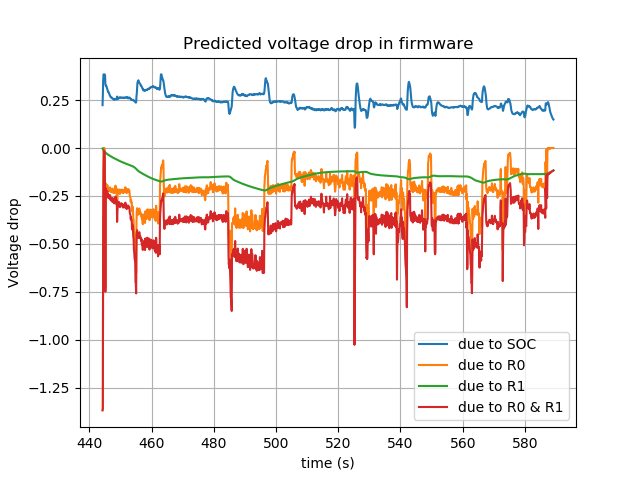

In [113]:
plt.figure()
plt.title('Predicted voltage drop in firmware')
plt.plot(time,kfbat.OCVcurve.OCVfromSOC(SOC)-voltage[0],label='due to SOC')
plt.plot(time,-R0*current,label='due to R0')
plt.plot(time,-R1*iR1,label='due to R1')
plt.plot(time,-R0*current-R1*iR1,label='due to R0 & R1')
plt.xlabel('time (s)')
plt.ylabel('Voltage drop')
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(simbat.simt,simbat.simi,label='iR0 sim')
plt.plot(simbat.simt[:n+1],xminus[1,:n+1],label='iR1 kf')
plt.plot(simbat.simt[:n+1],xminus[1,:n+1]+covxminus[1,1,:],color='C1',linestyle=':')
plt.plot(simbat.simt[:n+1],xminus[1,:n+1]-covxminus[1,1,:],color='C1',linestyle=':')
plt.legend()
plt.grid()

# State of charge comparison

## Comparison of Kalman filter results with simulation results

In [114]:
print(len(simbat.simt))
print(len(simbat.simz))
print(len(time))
print(np.shape(L))

1422
1423
1422
(2, 1422)


<IPython.core.display.Javascript object>


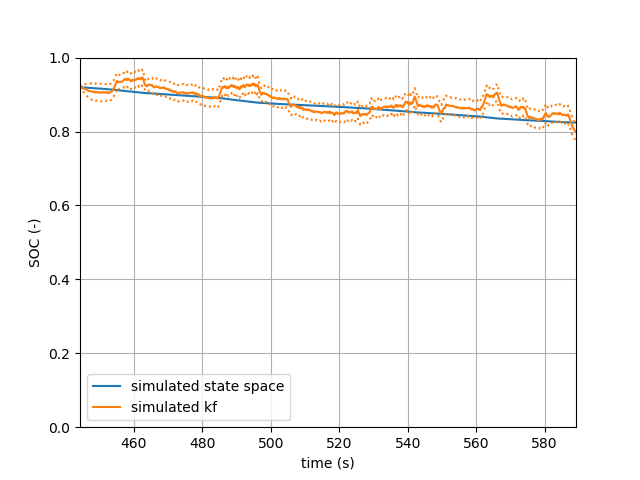

In [115]:
plt.figure()
plt.plot(simbat.simt[:n+1],simbat.simz[:n],label='simulated state space')
plt.plot(simbat.simt[:n+1],xplus[0,:],label='simulated kf')
plt.plot(simbat.simt[:n+1],xplus[0,:]+covxplus[0,0,:],linestyle=':',color='C1')
plt.plot(simbat.simt[:n+1],xplus[0,:]-covxplus[0,0,:],linestyle=':',color='C1')
plt.xlabel('time (s)')
plt.ylabel('SOC (-)')
plt.axis([time[0], time[-1], 0, 1])
plt.legend()
plt.grid()
plt.show()

Real SOC is certainly more like the simulation one. How much off is the KF ?

<IPython.core.display.Javascript object>


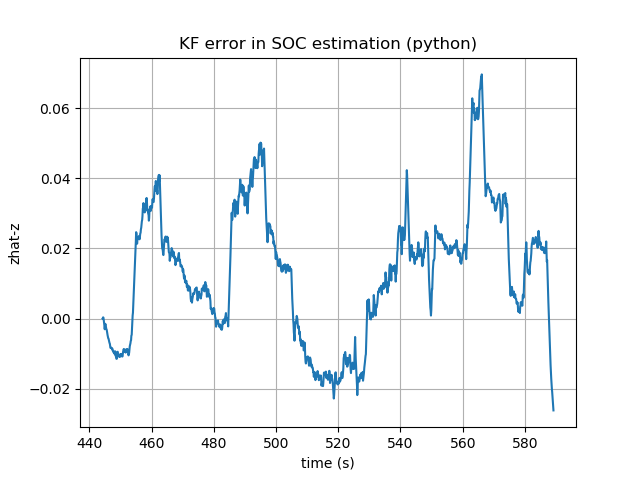

Mean error is 0.013280327447045668
Standard deviation is 0.018935492691194374
[]


In [116]:
plt.figure()
plt.plot(time[:n+1],xplus[0,:]-simbat.simz[:n])
print(f'Mean error is {np.mean(xplus[0,:]-simbat.simz[:n])}')
print(f'Standard deviation is {np.std(xplus[0,:]-simbat.simz[:n])}')
plt.grid()
plt.title('KF error in SOC estimation (python)')
plt.xlabel('time (s)')
plt.ylabel('zhat-z')
plt.show()
print(time[xplus[0,:]>0.99])

There is pike in SOC estimation of 15% arond 60s

## Comparison of Kalman filter results with firmware ones

<IPython.core.display.Javascript object>


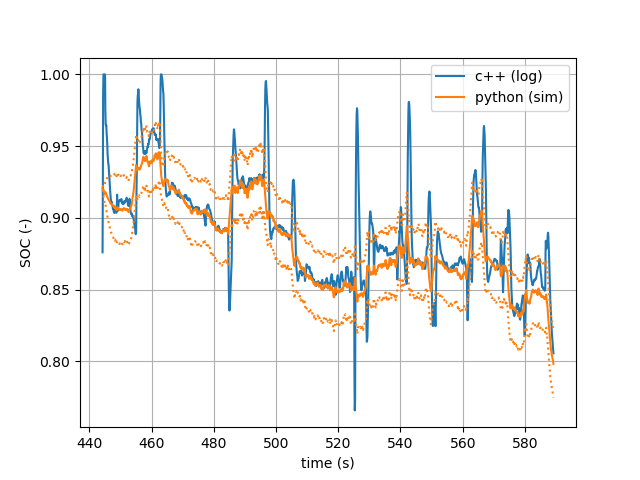

In [117]:
plt.figure()
plt.plot(time,SOC,label='c++ (log)')
plt.plot(time[:n+1],xplus[0,:],label='python (sim)')
plt.plot(simbat.simt[:n+1],xplus[0,:]+covxplus[0,0,:],linestyle=':',color='C1')
plt.plot(simbat.simt[:n+1],xplus[0,:]-covxplus[0,0,:],linestyle=':',color='C1')
plt.xlabel('time (s)')
plt.ylabel('SOC (-)')
plt.legend()
plt.grid()

# Looking for origin of chage in SOC

## Comparison between state prediction and measurement update

<IPython.core.display.Javascript object>


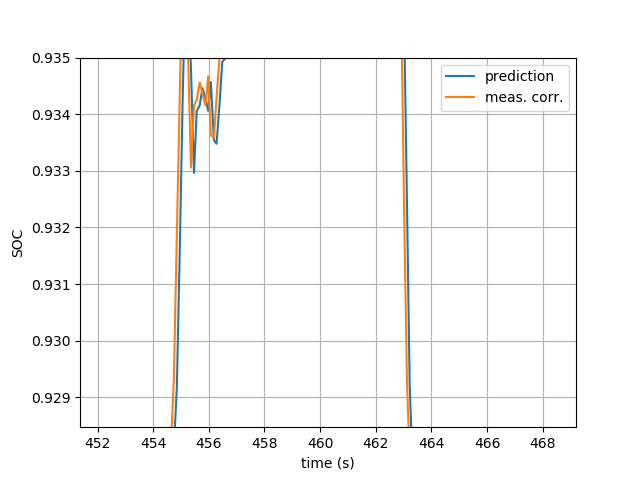

In [118]:
plt.figure()
plt.plot(time,xminus[0,:],label='prediction')
plt.plot(time,xplus[0,:],label='meas. corr.')
plt.xlabel('time (s)')
plt.ylabel('SOC')
plt.legend()
plt.grid()

The measurement correction leads and drives the changes !

## Kalman gain & innovation comparison

In [119]:
Ly0 = []
Ly1 = []
for k in range(n):
    Ly0 = np.append(Ly0,L[0,k]*(y[k]-yhat[k]))
    Ly1 = np.append(Ly1,L[1,k]*(y[k]-yhat[k]))

<IPython.core.display.Javascript object>


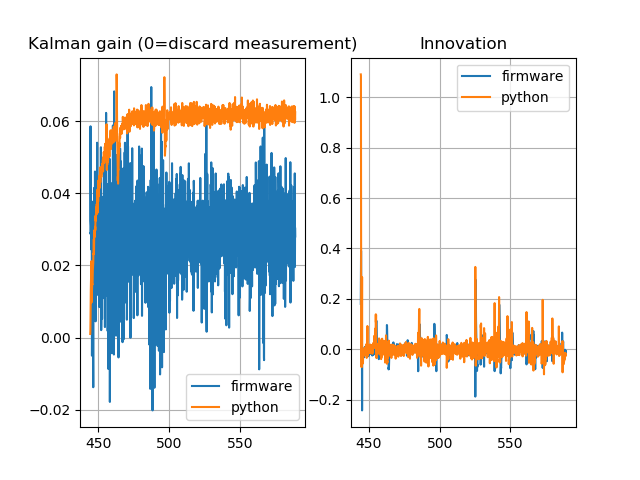

<IPython.core.display.Javascript object>


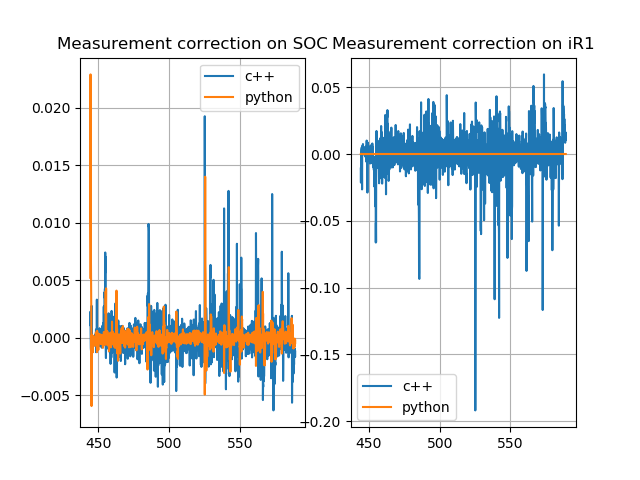

In [120]:
%matplotlib notebook

plt.figure()
plt.subplot(121)
plt.title('Kalman gain (0=discard measurement)')
plt.plot(time,kalman_gain[0,:].transpose(),label='firmware')
plt.plot(time,L[0,:],label='python')
plt.grid()
plt.legend()

plt.subplot(122)
plt.title('Innovation')
plt.plot(time,innovation,label='firmware')
plt.plot(time,y-yhat,label='python') # inno = y - yhat
plt.legend()
plt.grid()

plt.figure()
plt.subplot(121)
plt.title('Measurement correction on SOC')
plt.plot(time[:n],Ly0,label='c++')
plt.plot(time[:],measurement_update0,label='python')
plt.grid()
plt.legend()

plt.subplot(122)
plt.title('Measurement correction on iR1')
plt.plot(time[:n],Ly1,label='c++')
plt.plot(time[:],measurement_update1,label='python')
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.subplot(211)
plt.ylabel('Measurement correction on SOC')
plt.plot(time[:],measurement_update0,label='c++')
plt.plot(time[:n],Ly0,label='python')
plt.grid()
plt.legend()

plt.subplot(212)
plt.ylabel('innovation')
plt.xlabel('time (s)')
plt.plot(time[:],innovation,label='c++')
plt.plot(time[:n+1],y[:n+1]-yhat,label='python')
plt.grid()

<IPython.core.display.Javascript object>


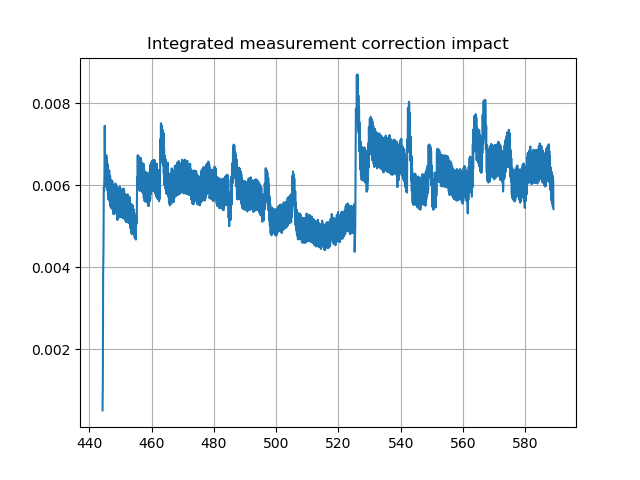

In [121]:
int_meascorr0 = np.cumsum(measurement_update0)[:-1]*np.diff(time)
plt.figure()
plt.title('Integrated measurement correction impact')
plt.plot(time[:-1],int_meascorr0)
plt.grid()

## SOC prediction due to state-space equation

In [114]:
wrong_timedelta = time[1:] #what is in logs up to 91
timedelta = np.diff(time)
A11 = [np.exp(-0.01/(R1*C1))]
A11 = A11 + list(np.exp(-timedelta/(R1*C1)))
print(Q/3.6)
B0 = [0.01/Q]
B0 = B0 + list(timedelta/Q)
wrong_B0 = [0.01/Q] + list(wrong_timedelta/Q)
print(B0[600])

6500.0
3.8932905982907666e-06


<IPython.core.display.Javascript object>


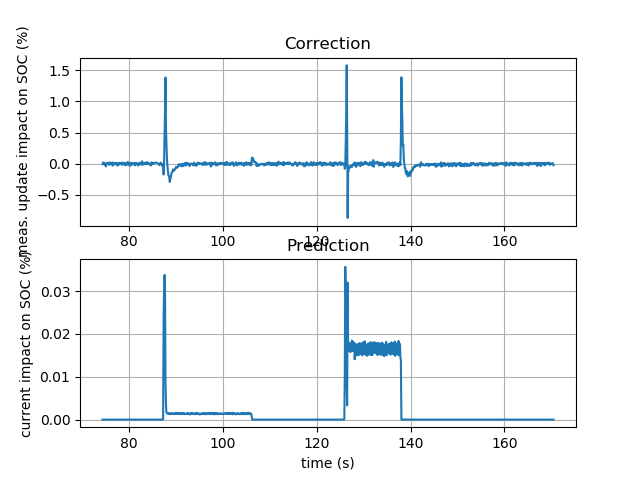

In [115]:
plt.figure()
plt.subplot(211)
plt.plot(time,measurement_update0*100)
plt.title('Correction')
plt.ylabel('meas. update impact on SOC (%)')
plt.grid() 

plt.subplot(212)
plt.plot(time,B0*current*100)
plt.title('Prediction')
plt.ylabel('current impact on SOC (%)')
plt.xlabel('time (s)')
plt.grid()

current is the only thing that makes the SOC predicition go up ! 30% is due to wrong B matrix due to wrong dt